## Averaged flows


In [6]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean
import os
import sys, time,random

sys.path.append('../defect_functions') 
from defect_pairs import * 

# sys.path.append('../vasco_scripts')  # add the relative path to the folder
# from defects import *  # import the module from the folder

# def progressBar(count_value, total, suffix=''):
#     bar_length = 100
#     filled_up_Length = int(round(bar_length* count_value / float(total)))
#     percentage = round(100.0 * count_value/float(total),1)
#     bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
#     sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
#     sys.stdout.flush()

%matplotlib qt

experiment = "s19" 

# def divergence_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dx = np.gradient(Fx, axis=0)
#     dFy_dy = np.gradient(Fy, axis=1)
#     return dFx_dx + dFy_dy

# def curl_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dy = np.gradient(Fx, axis=1)
#     dFy_dx = np.gradient(Fy, axis=0)
#     curl = dFy_dx - dFx_dy
#     return curl

# def analyze_defects(img):
#     # Calculate mgrid
#     yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
#     # Calculate orientation analysis
#     ori, coh, E = orientation_analysis(img, 25)
    
#     # Compute topological charges
#     k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
#     # Localize defects
#     defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
#     # Compute defect orientation
#     compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
#     # Filter defects by charge
#     plushalf = defects[defects['charge']==.5]
#     minushalf = defects[defects['charge']==-.5]
    
#     return ori, plushalf, minushalf



# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [2]:
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

PLOT = True

# image_list = glob.glob(r"C:/Users/victo/Downloads/SB_lab/RPE1_C2C12_/Test001/*.tif")
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[20:120:1]

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
    # v = np.zeros_like(u)


for im1, im2 in zip(image_list[:-1], image_list[1:]):
    print(os.path.basename(im1))
    img1 = cv2.imread(im1)[:,:,0]
    
    # calculate velocity and plot fields
    if PLOT:
        ax.clear()
        img2 = cv2.imread(im2)[:,:,0]
        flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
        # >> uncomment to have average flow representation
        # >>  TO DO devide by number of frames
        # u += flow[..., 0]
        # v += flow[..., 1]
        # flow = np.stack((u, v), axis=-1)

        divergence = gaussian_filter(divergence_npgrad(flow), sigma=30)

        # Apply Contrast Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(255-img_clahe, "gray")
        ax.imshow(divergence, "jet", alpha=.3, vmin=-0.03, vmax=0.03)

    ori, plushalf, minushalf = analyze_defects(img1)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_t")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)
    
    if PLOT:
        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
    
    
        save_path = os.path.join(
            r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
            experiment,
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))
    break    

minushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/MinusHalf1.csv")
plushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusHalf1.csv")

RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t21.TIF


In [3]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

In [4]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
        experiment,
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             


    # break



## Import CSVs

In [5]:
first_frame, last_frame

NameError: name 'first_frame' is not defined

In [ ]:
experiment = "s14" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders
last_frame = minushalf_df["frame"].max() # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_df[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

## Find shift and rescale

In [ ]:
from sklearn import linear_model

%matplotlib inline
frame = 1

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        # !!! insert image height (e.g. 2048)
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

### Validate shift and rescale

In [ ]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 1

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [ ]:
%matplotlib qt
# SLOPEx = 2.2020369696888773
# INTERCEPTx = -153.5892752236614
# SLOPEy = 2.589611169431241
# INTERCEPTy = -152.43827493084723

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

experiment = "s14" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [ ]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


In [ ]:
# replace and add angles
# plushalf_TM[['x_img1','y_img1','ang1','charge']] =  plushalf_df[['x', 'y', 'ang1', 'charge']].iloc[idx[:]].values

In [ ]:
# test replaced values
%matplotlib inline
frame = 20

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [ ]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")

# Start Here Find Pairs

In [15]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random
sys.path.append('../defect_functions') 
from defect_pairs import * 


# def divergence_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dx = np.gradient(Fx, axis=0)
#     dFy_dy = np.gradient(Fy, axis=1)
#     return dFx_dx + dFy_dy

# def curl_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dy = np.gradient(Fx, axis=1)
#     dFy_dx = np.gradient(Fy, axis=0)
#     curl = dFy_dx - dFx_dy
#     return curl

# def roll_func(what,basis,window,func,*args,**kwargs):
#     '''https://stackoverflow.com/questions/14300768/pandas-rolling-computation-with-window-based-on-values-instead-of-counts'''
#     from scipy.stats import circmean, circstd
#     #note that basis must be sorted in order for this to work properly     
#     indexed_what = pd.Series(what.values,index=basis.values)
#     def applyToWindow(val):
#         # using slice_indexer rather that what.loc [val:val+window] allows
#         # window limits that are not specifically in the index
#         indexer = indexed_what.index.slice_indexer(val,val+window,1)
#         chunk = indexed_what.iloc[indexer]
#         return func(chunk,*args,**kwargs)
#     rolled = basis.apply(applyToWindow)
#     return rolled

# def plot_rolling_average(df,ax, what_key, basis_key, show=True, win=15, color="red", avfunc=circmean, stdfunc=circstd, *args,**kwargs):
#     df = df.sort_values(by=basis_key)
#     df[what_key+"_ave"] = roll_func(df[what_key], df[basis_key], win, avfunc, *args,**kwargs)*180/np.pi
#     df[what_key+"_std"] = roll_func(df[what_key], df[basis_key], win, stdfunc)*180/np.pi
#     if show:
#         ax.plot(df.distance, df[what_key+"_ave"], "-", color=color, alpha=.6, linewidth=3)
#         ax.fill_between(df[basis_key], 
#                         df[what_key+"_ave"]-df[what_key+"_std"], 
#                         df[what_key+"_ave"]+df[what_key+"_std"], 
#                         color=color, alpha=.2) 
#     return df[[basis_key, what_key+"_ave", what_key+"_std"]] 

# def plot_rolling_average(df,ax, what_key, basis_key, show=True, win=15, color="red", avfunc=circmean, stdfunc=circstd, *args,**kwargs):
#     rad2deg = 180/np.pi if avfunc==circmean else 1.
#     df = df.sort_values(by=basis_key)
#     df[what_key+"_ave"] = roll_func(df[what_key], df[basis_key], win, avfunc, *args,**kwargs)*rad2deg
#     df[what_key+"_std"] = roll_func(df[what_key], df[basis_key], win, stdfunc)*rad2deg
#     df[what_key+"_count"] = roll_func(1.*df[what_key].abs(), df[basis_key], win, np.sum)
#     if show:
#         ax.plot(df[basis_key], df[what_key+"_ave"], "-", color=color, alpha=.6, linewidth=3)
#         ax.fill_between(df[basis_key], 
#                         df[what_key+"_ave"]-df[what_key+"_std"]/df[what_key+"_count"]**.5, 
#                         df[what_key+"_ave"]+df[what_key+"_std"]/df[what_key+"_count"]**.5, 
#                         color=color, alpha=.2) 
#     return df[[basis_key, what_key+"_ave", what_key+"_std", what_key+"_count"]]      

# def msd_from_df(df,xlabel,ylabel,tlabel,id_label,minimal_track=3):
#     def msd(x,y):
#         return np.cumsum(np.diff(x))**2 + np.cumsum(np.diff(y))**2

#     msds = []
#     for id in df[id_label].unique():
#         idx = (df[id_label]==id)
#         df_ = df[idx].copy()
#         if idx.sum()>minimal_track:
#             t = df_[tlabel].to_numpy()
#             x = df_[xlabel].to_numpy()
#             y = df_[ylabel].to_numpy()
#             msds.append(pd.DataFrame({"FRAME": t[1:]-t[0], 'MSD':msd(x,y)}).dropna())            
#     msd_df = pd.concat(msds)
#     return msd_df[msd_df["FRAME"]>0]

# def ang_msd_from_df(df,xlabel,tlabel,id_label,period=2*np.pi, minimal_track=3):
#     def msd(x):
#         x = np.unwrap(x, period=period)
#         return np.cumsum(np.diff(x))**2

#     msds = []
#     for id in df[id_label].unique():
#         idx = (df[id_label]==id)
#         df_ = df[idx].copy()
#         if idx.sum()>minimal_track:
#             t = df_[tlabel].to_numpy()
#             x = df_[xlabel].to_numpy()
#             msds.append(pd.DataFrame({"FRAME": t[1:]-t[0], 'MSD':msd(x)}).dropna())   
#     msd_df = pd.concat(msds)
#     return msd_df[msd_df["FRAME"]>0]

experiment = "s19"
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID901391,901391,26.0,81.421509,657.0,88.0,0.0,0.0,0,...,0.973672,1.625018,1293.144897,1972.526759,1293.0,1972.0,2.073451,NaN,NaN,0.5
1,1,ID901390,901390,89.0,81.421509,860.0,86.0,0.0,0.0,0,...,0.973672,1.625018,1740.161345,1977.706022,1740.0,1978.0,0.000000,NaN,NaN,0.5
2,2,ID901405,901405,124.0,74.827904,242.0,205.0,0.0,0.0,0,...,0.977139,1.318006,379.293538,1669.539881,380.0,1670.0,-1.570796,NaN,NaN,0.5
3,3,ID901404,901404,35.0,81.421509,844.0,192.0,0.0,0.0,0,...,0.973672,1.625018,1704.928521,1703.205090,1705.0,1704.0,1.319469,NaN,NaN,0.5
4,4,ID901407,901407,34.0,81.421509,718.0,220.0,0.0,0.0,0,...,0.973672,1.625018,1427.470036,1630.695409,1427.0,1632.0,-1.759292,NaN,NaN,0.5


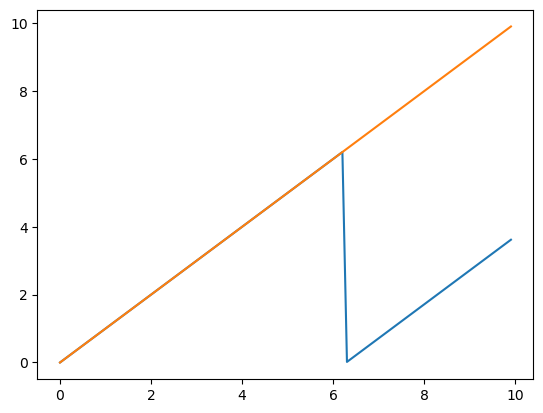

In [2]:
ang = np.arange(0,10,.1)
mod_ang = ang % (2*np.pi)
plt.plot(ang, mod_ang)
plt.plot(ang, np.unwrap(mod_ang, period=(2*np.pi)))

<AxesSubplot: xlabel='x_img1', ylabel='y_img1'>

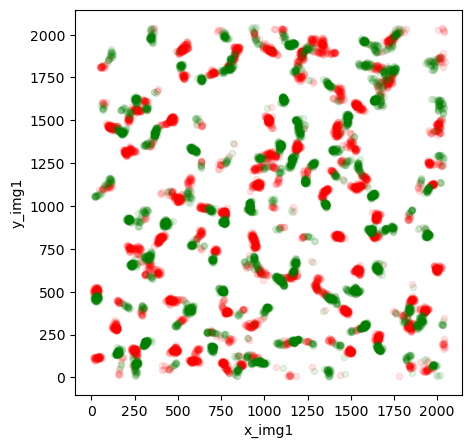

In [3]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plus_minus_df[plus_minus_df.charge==.5].plot.scatter("x_img1","y_img1", ax=ax1,c="r", alpha=.1)
plus_minus_df[plus_minus_df.charge==-.5].plot.scatter("x_img1","y_img1", ax=ax1,c="g", alpha=.1)

## Number of Defects over time

Text(0.5, 1.0, '$Number ~of ~\\pm 1/2 ~defects$')

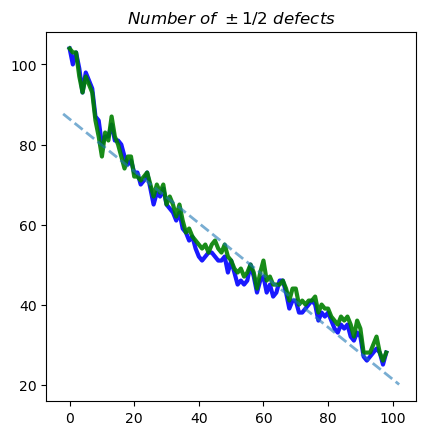

In [4]:
charge_av = []
charge_std = []
charge_p = []
charge_n = []
for frame in plus_minus_df.FRAME.unique():
    # charge_av.append(plus_minus_df.charge[plus_minus_df.FRAME==frame].sum())
    # charge_std.append(plus_minus_df.charge[plus_minus_df.FRAME==frame].std())
    charge_p.append(plus_minus_df.charge[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())
    charge_n.append(plus_minus_df.charge[~(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())

charge_av = np.array(charge_av)
charge_std = np.array(charge_std)
# plt.plot(plus_minus_df.FRAME.unique(), charge_av, "o")
# plt.fill_between(plus_minus_df.FRAME.unique(), 
#                 charge_av - charge_std, 
#                 charge_av + charge_std, 
#                 color=color, alpha=.2) 
plt.plot(plus_minus_df.FRAME.unique(), 2*np.abs(charge_n), "-b", alpha=.9, linewidth=3)
plt.plot(plus_minus_df.FRAME.unique(), 2*np.array(charge_p), "-g", alpha=.9, linewidth=3)

plt.gca().set_box_aspect(1)


from sklearn import linear_model
lr = linear_model.TheilSenRegressor()
X = np.array(plus_minus_df.FRAME.unique()).reshape(-1, 1)
y = 2*np.array(charge_p)

lr.fit(X, y)
line_X = np.arange(X.min()-2, X.max()+5)[:, np.newaxis]
line_y = lr.predict(line_X)
plt.plot(line_X, line_y, "--", linewidth=2, alpha=.6)   
plt.title(r"$Number ~of ~\pm 1/2 ~defects$")
        

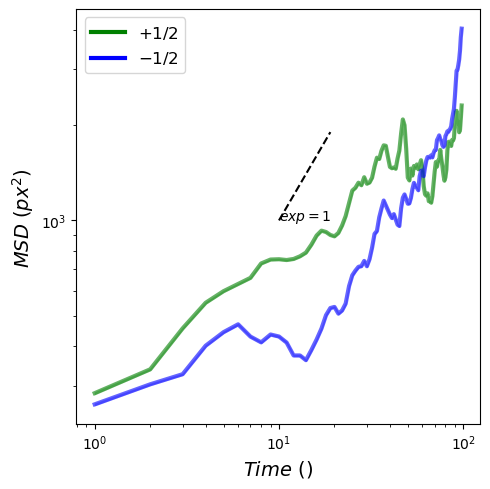

In [5]:
msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"x_img1","x_img1","FRAME","TRACK_ID")
msd_minus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==-.5],"x_img1","x_img1","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(10, 20, 1)
ax2.plot(xref, 1e2*xref**1,"--k")
ax2.text(xref[0], 1e2*xref[0]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

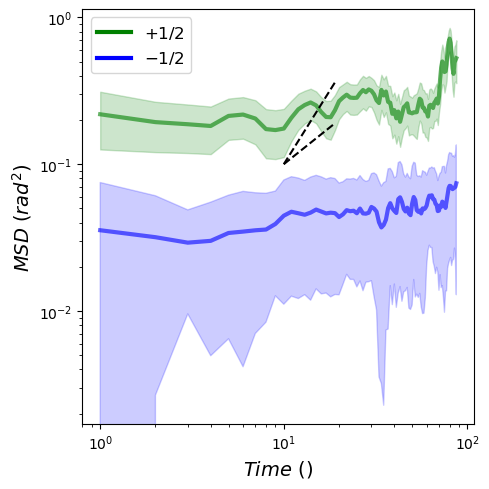

In [6]:
# plus_minus_df["angm_ave"] = circmean(plus_minus_df[["ang1","ang2","ang2"]], high=2/3*np.pi, axis=1)
plus_minus_df["angm_ave"] = plus_minus_df["ang1"] % (2/3*np.pi)
plus_minus_df1 = plus_minus_df[["ang1","angm_ave","charge","FRAME","TRACK_ID"]]

msd_plus_df = ang_msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME>10)],
                              "ang1","FRAME","TRACK_ID", minimal_track=20)
msd_minus_df = ang_msd_from_df(plus_minus_df1[(plus_minus_df1.charge==-.5)&(plus_minus_df.FRAME>10)],
                               "angm_ave","FRAME","TRACK_ID",period=2/3*np.pi, minimal_track=20)


# msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"ang1","ang1","FRAME","TRACK_ID",minimal_track=10)
# msd_minus_df = msd_from_df(plus_minus_df1[plus_minus_df1.charge==-.5],"angm_ave","angm_ave","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1
 
for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 
    # TODO check the "count" 
    # break


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(10, 20, 1)
ax2.plot(xref, 1e-2*xref**1, "--k", xref, 1e-3*xref**2, "--k",)
# ax2.text(xref[-1], .5*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(rad^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

(<AxesSubplot: >, <AxesSubplot: >)

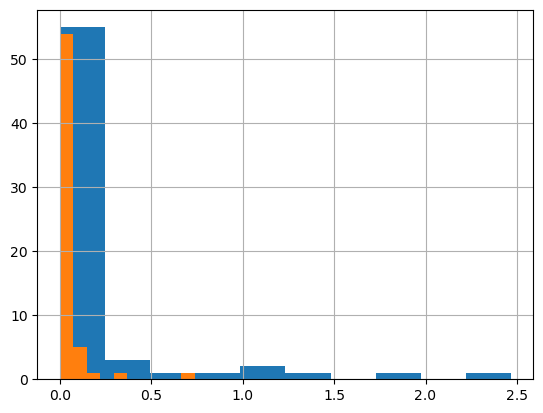

In [7]:
msd_plus_df.MSD[msd_plus_df.FRAME==1].hist(), msd_minus_df.MSD[msd_minus_df.FRAME==1].hist()

In [8]:
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)

pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<50
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 
    # break

pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna()#.drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [9]:
radius = 400
neighbour_dist = []
for frame in plus_minus_df["FRAME"].unique()[:]:
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    tree = KDTree(plus_xy[["x_img1","y_img1"]]) #map all +1/2 defects

    # for each -1/2 map distances to +1/2 neighbours in RADIUS
    for index, row in minus_xy.iterrows():
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind, dist = tree.query_radius(np.array(row[['x_img1','y_img1']]).reshape(1, -1), 
                                      r=radius, return_distance=True, sort_results=True)
        # find [-1/2, +1/2] pair TRACK_IDs
        try:
            plus_neighbours = plus_xy.iloc[ind[0]].copy()
            plus_neighbours["DIST"] = dist[0]
            plus_pair_id = pairs_df["plus"][pairs_df["minus"]==row["TRACK_ID"]].values[0]
            plus_neighbours["PAIR"] = (plus_neighbours["TRACK_ID"] == plus_pair_id)
            plus_neighbours["mTRACK_ID"] = row["TRACK_ID"]

            plus_neighbours["mp_ang"] = np.arctan2(
                row['y_img1']-plus_neighbours["y_img1"], 
                row['x_img1']-plus_neighbours["x_img1"]
                ) % (2*np.pi)

            plus_neighbours["p_ang_rel"] = (plus_neighbours["ang1"] - plus_neighbours["mp_ang"]) % (2*np.pi)

            plus_neighbours["delta_ang1"] = (row["ang1"] - plus_neighbours["ang1"])
            plus_neighbours["delta_ang2"] = (row["ang2"] - plus_neighbours["ang1"])
            plus_neighbours["delta_ang3"] = (row["ang3"] - plus_neighbours["ang1"])

            plus_neighbours["p_ang"] = plus_neighbours["ang1"]
            plus_neighbours["px_img1"] = plus_neighbours["x_img1"]
            plus_neighbours["py_img1"] = plus_neighbours["y_img1"]
            
            plus_neighbours["mx_img1"] = row["x_img1"]
            plus_neighbours["my_img1"] = row["y_img1"]
            plus_neighbours["m_ang1"] = row["ang1"]
            plus_neighbours["m_ang2"] = row["ang2"]
            plus_neighbours["m_ang3"] = row["ang3"]

            neighbour_dist.append(plus_neighbours[[
                "PAIR","DIST","p_ang_rel", "TRACK_ID", 
                "delta_ang1","delta_ang2","delta_ang3",
                "p_ang", "px_img1", "py_img1",
                "mx_img1", "my_img1",
                "m_ang1", "m_ang2", "m_ang3", "mTRACK_ID"
                ]])
        except:
            pass

    #     break
neighbour_dist = pd.concat(neighbour_dist).dropna()
# grouped = neighbour_dist.groupby('TRACK_ID')["p_ang_rel"]
# neighbour_dist["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi).astype('bool')

In [10]:
neighbour_dist["mp_angle"] = np.arctan2(neighbour_dist["my_img1"]-neighbour_dist["py_img1"], 
                                      neighbour_dist["mx_img1"]-neighbour_dist["px_img1"]) % (2*np.pi)


neighbour_dist["angp1_rel"] = (neighbour_dist["p_ang"] - neighbour_dist["mp_angle"]) % (2*np.pi)

grouped = neighbour_dist.groupby('TRACK_ID')["angp1_rel"]
neighbour_dist["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

In [11]:
neighbour_dist.keys(), neighbour_dist["PAIR"].sum()

(Index(['PAIR', 'DIST', 'p_ang_rel', 'TRACK_ID', 'delta_ang1', 'delta_ang2',
        'delta_ang3', 'p_ang', 'px_img1', 'py_img1', 'mx_img1', 'my_img1',
        'm_ang1', 'm_ang2', 'm_ang3', 'mTRACK_ID', 'mp_angle', 'angp1_rel',
        'fuse_up'],
       dtype='object'),
 2194)

<AxesSubplot: >

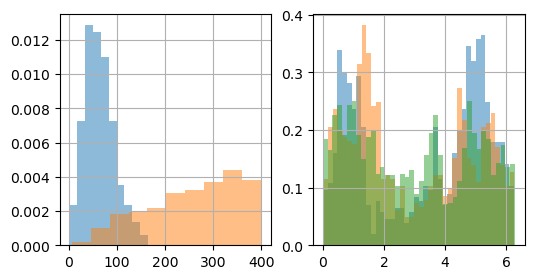

In [12]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
neighbour_dist.DIST[neighbour_dist["PAIR"]].hist(alpha=.5,density=True,ax=ax1)
neighbour_dist.DIST[~neighbour_dist["PAIR"]].hist(alpha=.5,density=True,ax=ax1)

(neighbour_dist.p_ang_rel[(
        (neighbour_dist["PAIR"]) & (neighbour_dist["fuse_up"]) & (neighbour_dist["DIST"]<120)
        )] % (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)

(neighbour_dist.p_ang_rel[(
        (neighbour_dist["PAIR"]) & (~neighbour_dist["fuse_up"]) & (neighbour_dist["DIST"]<120)
        )] % (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)   
         
(neighbour_dist.p_ang_rel[(
        (~neighbour_dist["PAIR"]) & (neighbour_dist["DIST"]<120)
        )]% (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)

Text(0.5, 1.0, '$Relative ~angle ~btw ~-1/2 ~and ~+1/2$')

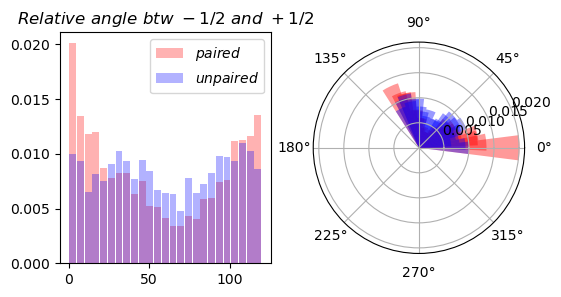

In [13]:
%matplotlib inline
max_dist = 90
paired_up, paired_down, unpaired, delta = [], [], [], []
for i in range(3):
    paired_up.append(neighbour_dist["delta_ang"+str(i+1)]
        [(neighbour_dist["PAIR"])\
        &(neighbour_dist["DIST"]<max_dist)\
        &(neighbour_dist["DIST"]<max_dist)\
        ].values)
    unpaired.append(neighbour_dist["delta_ang"+str(i+1)]
        [(~neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<max_dist)].values)

    # m_ang = neighbour_dist["m_ang"+str(i+1)][
    #         (neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<120)].values
    # p_ang = neighbour_dist["p_ang"][
    #         (neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<120)].values
    # delta.append(m_ang - p_ang)        

paired_up = np.concatenate(paired_up) % (2/3*np.pi)
unpaired = np.concatenate(unpaired) % (2/3*np.pi)
# delta = np.concatenate(delta) % (2/3*np.pi)

fig1 = plt.figure(figsize=(6,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 25  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2/3*np.pi, bins_number+1)

p1,_,_ = ax1.hist(paired_up*180/np.pi, bins*180/np.pi, #one peak 
                    density=True, rwidth=.9, alpha=.3, color="red", label=r"$paired$")
p2,_,_ = ax1.hist(unpaired*180/np.pi, bins*180/np.pi, #one peak 
                    density=True, rwidth=.9, alpha=.3, color="blue", label=r"$unpaired$")
# p3,_,_ = ax1.hist(delta*180/np.pi, bins*180/np.pi, #one peak 
#                     density=True, rwidth=.9, alpha=.3, color="g", label=r"$unpaired$")

width = 2 * np.pi / bins_number
ax2.bar(bins[:bins_number], p1, color="red", width=width, bottom=0.0, alpha=.4)    
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,)
# ax2.bar(bins[:bins_number], p3, color="g", width=width, bottom=0.0, alpha=.4,)  
ax1.legend(loc='upper right')    
ax1.set_title(r"$Relative ~angle ~btw ~-1/2 ~and ~+1/2$")                                  

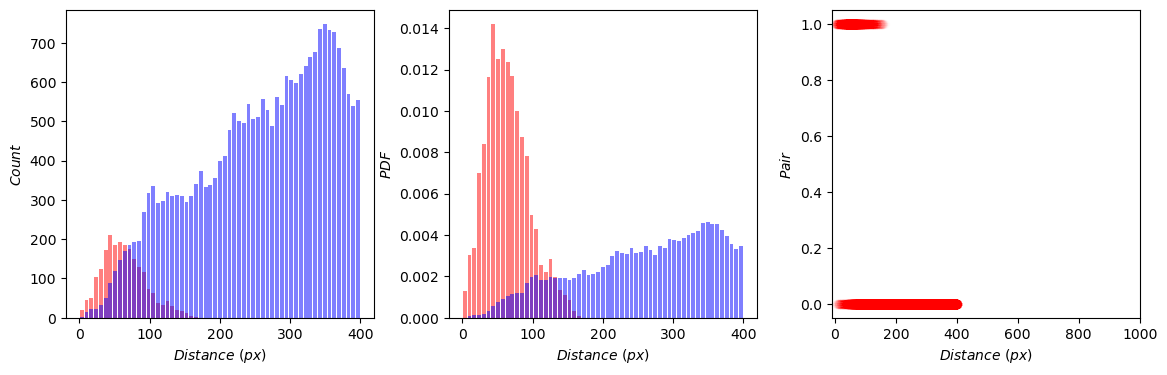

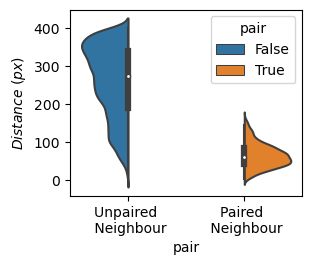

In [16]:
%matplotlib inline
    #     'PAIR', 'DIST', 'p_ang_rel', 'TRACK_ID', 
    #     'delta_ang1', 'delta_ang2', 'delta_ang3', 
    #     'p_ang', 'px_img1', 'py_img1', 
    #     'mx_img1', 'my_img1', 'm_ang1', 'm_ang2', 'm_ang3', 
    #    'mTRACK_ID', 'mp_angle', 'angp1_rel',
    #    'fuse_up'
                
df = neighbour_dist.set_axis(['pair', 'distance', 'p_ang_rel', 'TRACK_ID', 
                                "delta_ang1","delta_ang2","delta_ang3", 
                                'p_ang', 'px_img1', 'py_img1', 
                    'mx_img1', 'my_img1', 'm_ang1', 'm_ang2', 'm_ang3', 
                    'mTRACK_ID', 'mp_angle', 'angp1_rel',
                    'fuse_up'
                            ], axis=1).dropna()

bins_number = 60
bins = np.linspace(0, radius, bins_number)
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
# p1 = ax1.hist(distance[pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="red")
# p2 = ax1.hist(distance[~pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="blue")
p1 = ax1.hist(df["distance"][df["pair"]], bins, density=False, rwidth=.8, alpha=.5, color="red")
p1 = ax1.hist(df["distance"][~df["pair"]], bins, density=False, rwidth=.8, alpha=.5, color="blue")
ax1.set_xlabel("$Distance ~(px)$")
ax1.set_ylabel("$Count$")
ax1.set_box_aspect(1)

# p1 = ax2.hist(distance[pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="red")
# p2 = ax2.hist(distance[~pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="blue")
p1 = ax2.hist(df["distance"][df["pair"]], bins, density=True, rwidth=.8, alpha=.5, color="red")
p1 = ax2.hist(df["distance"][~df["pair"]], bins, density=True, rwidth=.8, alpha=.5, color="blue")
ax2.set_xlabel("$Distance ~(px)$")
ax2.set_ylabel("$PDF$")
ax2.set_box_aspect(1)

ax3.plot(df["distance"],df["pair"], "or", alpha=.01)
ax3.set_xlabel("$Distance ~(px)$")
ax3.set_ylabel("$Pair$")
ax3.set_xlim([-10,1000])
ax3.set_box_aspect(1)

# sns.violinplot([distance[pairs_idx], distance[~pairs_idx]], ax=ax3, split=True)

fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(data=df, x="pair", y="distance", ax=ax, hue="pair", split=True)
# sns.stripplot(data=df, x="pair", y="distance", ax=ax, marker=".", alpha=.01)
ax.set_xticklabels(["Unpaired \n Neighbour", "Paired \n Neighbour",])
ax.set_ylabel("$Distance ~(px)$")
ax.set_box_aspect(.8)

<BarContainer object of 45 artists>

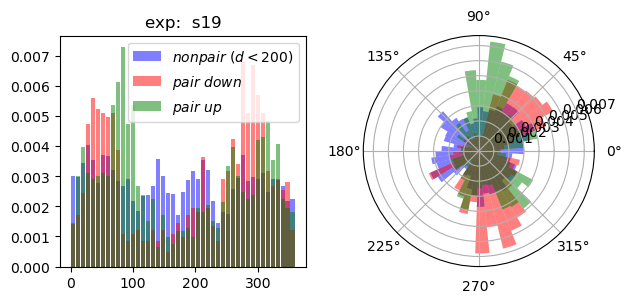

In [17]:
%matplotlib inline
SAVE = False
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
nonpair_ang = df["p_ang_rel"][
    np.logical_and(~df["pair"], df["distance"]<150)
    ] % (2*np.pi)
pair_ang_up = df["p_ang_rel"][(df["pair"])&(df["fuse_up"])] % (2*np.pi)
pair_ang_down = df["p_ang_rel"][(df["pair"])&(~df["fuse_up"])] % (2*np.pi)

fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

ax1.set_title(r"exp:  " + experiment)
nonpair, _, _ =  ax1.hist(nonpair_ang*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="blue", label="$nonpair~(d<200)$")
pair_up, _, _ =  ax1.hist(pair_ang_up*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="red", label="$pair ~down$")
pair_down, _, _ =  ax1.hist(pair_ang_down*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="g", label="$pair ~up$")    

ax1.legend(loc='upper right')

width = 2 * np.pi / bins_number
ax2.bar(bins[:bins_number], nonpair, color="blue",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], pair_up, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], pair_down, color="g",width=width, bottom=0.0, alpha=.5)
# if SAVE:
#     fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/pair-nonpair_ang_distribution_hist_" + experiment +".png")


<AxesSubplot: xlabel='mp_angle', ylabel='distance'>

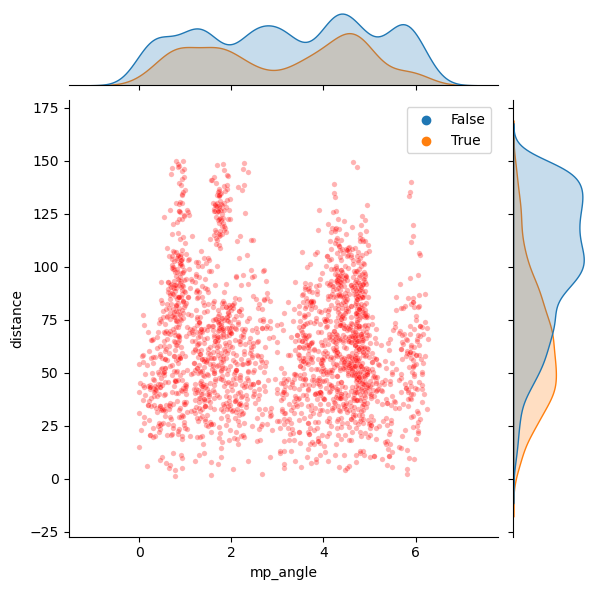

In [18]:
nonpair_ang = df[["mp_angle", "distance","pair"]][
    # np.logical_and(df["pair"]==1, df["distance"]<200)
    df["distance"]<150#df["distance"][df["pair"]==1].max()
    ]
nonpair_ang["mp_angle"] = nonpair_ang["mp_angle"] % (2*np.pi)
g = sns.jointplot(data=nonpair_ang, x="mp_angle", y="distance", 
     hue="pair", alpha=.0, marker=".",)

sns.scatterplot(x=nonpair_ang["mp_angle"][nonpair_ang["pair"]==0], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==0], 
    s=0, color="blue", ax=g.ax_joint, alpha=.2)   

sns.scatterplot(x=nonpair_ang["mp_angle"][nonpair_ang["pair"]==1], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==1], 
    s=15, color="red", ax=g.ax_joint, alpha=.3) 

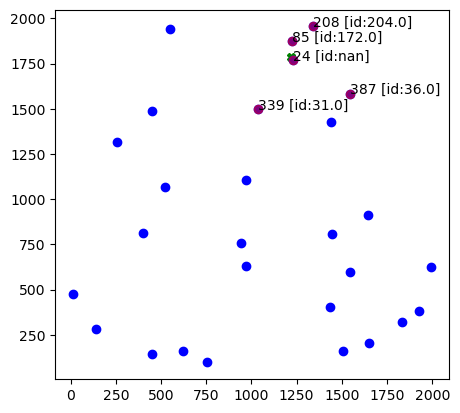

In [19]:
%matplotlib inline
plt.plot(row['x_img1'], row['y_img1'], "Xg")
plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], "ob")
plt.plot(plus_xy["x_img1"].iloc[ind[0]], plus_xy["y_img1"].iloc[ind[0]], "or", alpha=.5)
for ii,dd in zip(ind[0],dist[0]):
    plt.text(plus_xy["x_img1"].iloc[ii], plus_xy["y_img1"].iloc[ii],
        "%2d [id:%s]" % (dd, plus_xy["TRACK_ID"].iloc[ii])
        )

plt.gca().set_aspect(1)

### for each -1/2 defect find the closest +1/2 neighbour, which is not his pair

%matplotlib qt


def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

def pair_trajectories(mlabel, plabel, minimal_track=15):
    m_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==mlabel, 
        plus_minus_df["charge"]==-.5,
        )
    p_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==plabel, 
        plus_minus_df["charge"]==.5
        )
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:
        return equlalize_trajectories(plus_minus_df, p_idx, m_idx)
    
def get_non_pair_pdef():
    df = pd.DataFrame(columns=["FRAME","TRACK_ID","x_img1","y_img1","ang1"])
    maximal_pair_distance = 1.5*center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
    for num,frame in enumerate(dff_.index):
        p_idx = np.logical_and.reduce((
            plus_minus_df["FRAME"]==frame, 
            plus_minus_df["charge"]==.5,
            plus_minus_df["TRACK_ID"] != n,
        ))
        plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

        tree = KDTree(plus_xy[["x_img1","y_img1"]])
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]
        
        if len(ind):
            df = pd.concat([df, plus_xy[["FRAME","TRACK_ID","x_img1","y_img1","ang1"]].iloc[ind]])

    df.set_index('FRAME', inplace=True)
    return df

non_pair_rel_angle = []
fig, ax = plt.subplots(1,1, figsize=(10,10))  
count = 0
for m, n in zip(pairs_df["minus"][:], pairs_df["plus"][:40]):
    dff_ = pair_trajectories(m,n)    
    
    if dff_ is not None:
        maximal_pair_distance = center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
        # plt.figure()        
        # count +=1
        # print(count)
        # if count>20:
        #     break
        
        # find next nearest neighbour, which is not a pair
        colors = plt.cm.jet(np.linspace(0, 1, num=len(dff_)))
        non_pair_df = get_non_pair_pdef()
        mp_angle = np.arctan2(np.median(dff_["ym"]) - np.median(non_pair_df["y_img1"]), 
                            np.median(dff_["xm"]) - np.median(non_pair_df["x_img1"])) 
        if mp_angle<0:
            mp_angle = mp_angle + 2*np.pi

        non_pair_df["rel_ang"] = non_pair_df["ang1"] - mp_angle
        non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] = non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] + 2*np.pi

        if len(non_pair_df):
            non_pair_rel_angle.append(
                circmean(non_pair_df["rel_ang"])
                )
            # print(non_pair_df.head())
            # break        

        for num,frame in enumerate(dff_.index):
            p_idx = np.logical_and.reduce((
                plus_minus_df["FRAME"]==frame, 
                plus_minus_df["charge"]==.5,
                # plus_minus_df["TRACK_ID"] != n,
            ))
            plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

            tree = KDTree(plus_xy[["x_img1","y_img1"]])
            # find +1/2 defects within radius (r=maximal_pair_distance)
            ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]

            # plt.figure()
            # non-pair neighbour
            plt.plot(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind], "or", alpha=.6)
            plt.quiver(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind],
                np.cos(plus_xy["ang1"].iloc[ind]), -np.sin(plus_xy["ang1"].iloc[ind]), 
                headaxislength=0, headwidth=0, headlength=0, color='r', scale=25, alpha=.6)

            # plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], ".b", alpha=.05)
            # plt.quiver(plus_xy["x_img1"], plus_xy["y_img1"],
            #     np.cos(plus_xy["ang1"]), -np.sin(plus_xy["ang1"]), 
            #     headaxislength=0, headwidth=0, headlength=0, color='b', scale=30, alpha=.05)

            circle1 = plt.Circle((dff_["xm"].loc[frame], dff_["ym"].loc[frame]), maximal_pair_distance, color='r', alpha=.05, fill=False)
            plt.gca().add_patch(circle1)
            # # plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], marker="$M$", color=colors[num])
            # # plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], marker="$P$", color=colors[num])

            # pair neighbours
            plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            for i in range(3):
                plt.quiver(dff_["xm"].loc[frame], dff_["ym"].loc[frame],
                    np.cos(dff_['angm'+str(i+1)].loc[frame]), -np.sin(dff_['angm'+str(i+1)].loc[frame]), 
                    headaxislength=0, headwidth=0, headlength=0, color='m', scale=35, alpha=.2) 

            plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            plt.quiver(dff_["xp"].loc[frame], dff_["yp"].loc[frame],
            np.cos(dff_["angp1"].loc[frame]), -np.sin(dff_["angp1"].loc[frame]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=45, alpha=.2)

plt.gca().set_box_aspect(1)

plt.figure()
plt.hist(np.array(non_pair_rel_angle)*180/np.pi,10, density=False, rwidth=.9, alpha=.5, color="red")

## Pair Trajectories

In [20]:
%matplotlib qt

# def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
#     ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
#     according to "FRAME" number
#     if missing frame for one of them it removed with dropna()
#     '''
#     df1 = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]
#     df1.set_index('FRAME', inplace=True)
#     df2 =  plus_minus_df[["TRACK_ID","FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
#     df2.set_index('FRAME', inplace=True)
#     df_ = pd.concat([df1, df2], axis=1).dropna()
#     return df_.set_axis(["plus_id","xp","yp","angp1", "min_id","xm","ym", "angm1","angm2","angm3"], axis=1)


minimal_track = 1

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
pair_stat = []
all_pairs_df = []
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (5 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        all_pairs_df.append(dff_)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        mp_distance.append(((xm-xp)**2 + (ym-yp)**2)**.5)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi)]
                          )

        for i in range(3):
            ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

        ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
        ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

        ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
        ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

        ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
        ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
        # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
        ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
        ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)

all_pairs_df = pd.concat(all_pairs_df)        

In [21]:
# vals, idx_start, count = np.unique(all_pairs_df.plus_id, return_counts=True, return_index=True)
# n = 10
# for i,c in zip(idx_start[n:],count[n:]):
#     print(all_pairs_df.plus_id.iloc[i:i+c].unique())
#     print(c)
#     break
# all_pairs_df.iloc[idx_start[n]:idx_start[n]+count[n]]
# all_pairs_df["p_vel_angle"] = np.arctan2(all_pairs_df.groupby('plus_id')["yp"].diff().fillna(0), 
#                                         all_pairs_df.groupby('plus_id')["xp"].diff().fillna(0))

In [22]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)


all_pairs_df["angp1_rel"] = (all_pairs_df["angp1"] - all_pairs_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    all_pairs_df["angm"+str(i+1)+"_rel"] = (all_pairs_df["angm"+str(i+1)] - all_pairs_df["mp_angle"]) % (2*np.pi)

grouped = all_pairs_df.groupby('plus_id')["angp1_rel"]
all_pairs_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

all_pairs_df["p_vel_angle"] = np.arctan2(all_pairs_df.groupby('plus_id')["yp"].diff(periods=3).fillna(0), 
                                        all_pairs_df.groupby('plus_id')["xp"].diff(periods=3).fillna(0))

all_pairs_df["p_vel_angle_rel"] = all_pairs_df["p_vel_angle"] - all_pairs_df["mp_angle"]                                 
all_pairs_df["p_vel_angle_rel"][all_pairs_df["p_vel_angle"]==0] = 0
# TODO p_angle relative to trajectory path
all_pairs_df["angp1_rel_vel_angle"] = (all_pairs_df["angp1"]- all_pairs_df["p_vel_angle"]) %(2*np.pi)

#### How +1/2 defects orient ralatively to axis of their movement

Text(0.5, 1.0, 'Angle of +1/2 defect movement \n its trajectory axis')

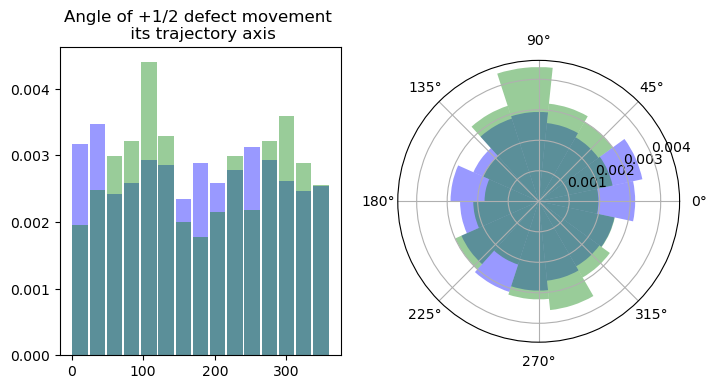

In [23]:
%matplotlib inline
bins_number = 15  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

df = all_pairs_df.reset_index()
up = df["angp1_rel_vel_angle"][(df["fuse_up"])&(df.distance<200)]
down = df["angp1_rel_vel_angle"][~(df["fuse_up"])&(df.distance<200)]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
# p0,_,_ = ax1.hist(all*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="r")
p1,_,_ = ax1.hist(up*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
p2,_,_ = ax1.hist(down*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="g")

# ax2.bar(bins[:bins_number], p0, color="r", width=width, bottom=0., alpha=.4)
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} > \pi)$" % (circmean(up, high=np.pi)*180/np.pi))
    # label="up: %.1f" % (circmean(up, high=np.pi)*180/np.pi))
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} < \pi)$"  % (circmean(down, high=np.pi)*180/np.pi))
# ax2.legend(fontsize=12)
ax1.set_title("Angle of +1/2 defect movement \n its trajectory axis")

#### How +1/2 defects move ralatively to axis between defect pair

 up: 176.5 [std: 53.3] 
 down: 166.2 [std: 49.7] 
 all: 170.6 [std: 51.6]


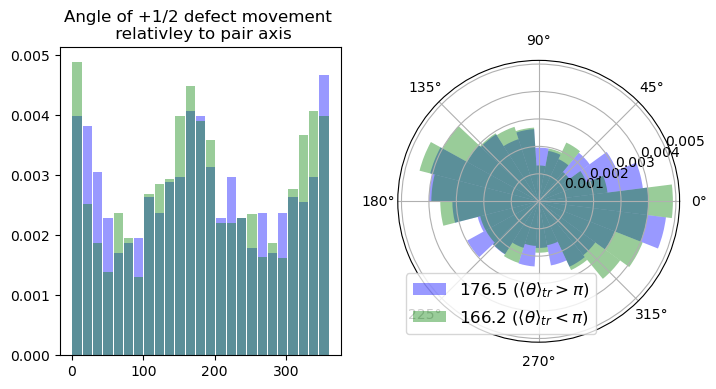

In [24]:
%matplotlib inline
bins_number = 25  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

all = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
up = all_pairs_df["p_vel_angle_rel"][(all_pairs_df["fuse_up"]) & ~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
down = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["fuse_up"]) & ~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
# ------- early/late
# up = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0) & (all_pairs_df.index<30)] % (2*np.pi)
# down = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0) & (all_pairs_df.index>60)] % (2*np.pi)


plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
# p0,_,_ = ax1.hist(all*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="r")
p1,_,_ = ax1.hist(up*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
p2,_,_ = ax1.hist(down*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="g")

# ax2.bar(bins[:bins_number], p0, color="r", width=width, bottom=0., alpha=.4)
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} > \pi)$" % (circmean(up, high=np.pi)*180/np.pi))
    # label="up: %.1f" % (circmean(up, high=np.pi)*180/np.pi))
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} < \pi)$"  % (circmean(down, high=np.pi)*180/np.pi))
ax2.legend(fontsize=12)
ax1.set_title("Angle of +1/2 defect movement \n relativley to pair axis")

print(
    " up: %.1f [std: %.1f] \n down: %.1f [std: %.1f] \n all: %.1f [std: %.1f]"
    % (circmean(up, high=np.pi)*180/np.pi, circstd(up, high=np.pi)*180/np.pi,
    circmean(down, high=np.pi)*180/np.pi, circstd(down, high=np.pi)*180/np.pi,
    circmean(all, high=np.pi)*180/np.pi, circstd(all, high=np.pi)*180/np.pi)
    )

<AxesSubplot: >

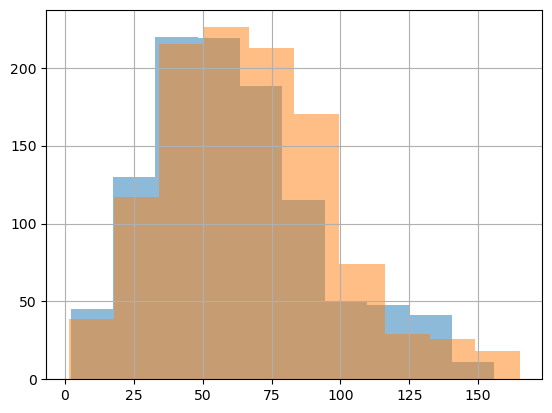

In [25]:
%matplotlib inline
all_pairs_df["distance"][all_pairs_df["fuse_up"]].hist(alpha=.5)
all_pairs_df["distance"][~all_pairs_df["fuse_up"]].hist(alpha=.5)

Text(0.5, 1.0, 'dist>40')

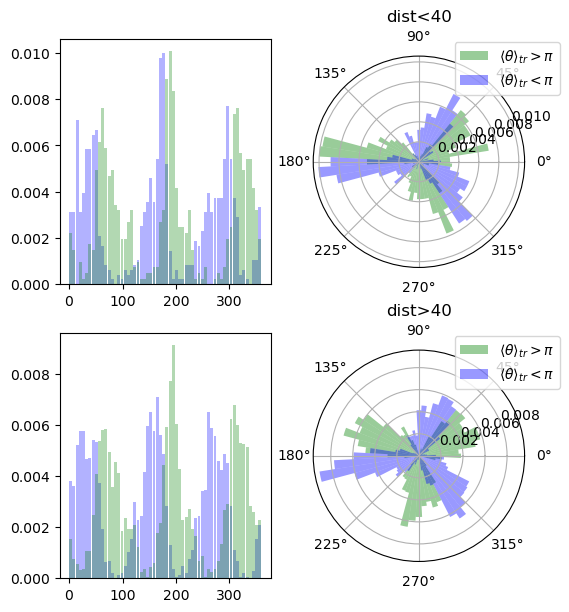

In [26]:
%matplotlib inline
fuse_df = all_pairs_df.copy()
dist = 40
m_ang_up_close, m_ang_down_close = [], []
m_ang_up_far, m_ang_down_far = [], []
for i in range(3):
    m_ang_up_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_down_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_up_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    m_ang_down_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    # break
    
m_ang_up_close = np.concatenate(m_ang_up_close) 
m_ang_down_close = np.concatenate(m_ang_down_close) 
m_ang_up_far = np.concatenate(m_ang_up_far) 
m_ang_down_far = np.concatenate(m_ang_down_far) 

fig1 = plt.figure(figsize=(6,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')

bins_number = 60  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

# p1,_,_ = ax1.hist((m_ang_up_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p1,_,_ = ax1.hist((m_ang_up_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p2,_,_ = ax1.hist(360-(-m_ang_down_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak flipped
# p2,_,_ = ax1.hist(m_ang_down_close % (2/3*np.pi)*180/np.pi, bins*180/np.pi, #one peak 
p2,_,_ = ax1.hist((m_ang_down_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax2.set_title("dist<%s" % dist)

# p3,_,_ = ax3.hist((m_ang_up_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p3,_,_ = ax3.hist((m_ang_up_far % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p4,_,_ = ax3.hist(360-(-m_ang_down_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak flipped
# p4,_,_ = ax3.hist((m_ang_down_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p4,_,_ = ax3.hist(m_ang_down_far % (2*np.pi)*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax4.bar(bins[:bins_number], p3, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax4.bar(bins[:bins_number], p4, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax4.legend(bbox_to_anchor=(1.2, 1.1)); ax4.set_title("dist>%s" % dist)

(FRAME
 5     190.844537
 33    187.106505
 95    187.213223
 7     188.872430
 48    188.872430
 Name: angm_rel_all_ave, dtype: float64,
 FRAME
 34    157.797058
 49    160.143734
 1     160.143734
 0     162.374716
 50    162.374716
 Name: angm_rel_all_ave, dtype: float64)

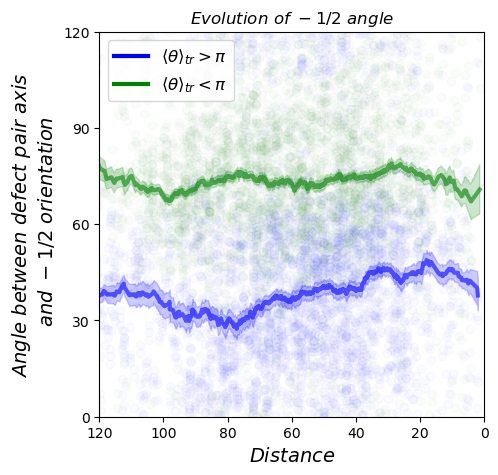

In [27]:
%matplotlib inline

df_all = fuse_df
win = 5

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

for i in range(3):
    y_up = df_all["angm"+str(i+1)+"_rel"][fuse_df["fuse_up"]] % (2/3*np.pi)
    y_down = df_all["angm"+str(i+1)+"_rel"][~fuse_df["fuse_up"]] % (2/3*np.pi)
    ax1.plot(df_all.distance[fuse_df["fuse_up"]], y_up*180/np.pi, "ob", alpha=.02)
    ax1.plot(df_all.distance[~fuse_df["fuse_up"]], y_down*180/np.pi, "og", alpha=.02)
    # plt.plot(df_all.distance[~fuse_df["fuse_up"]], -120+(y_down*180/np.pi), "og", alpha=.02)

m_ang_all = []
for i in range(3):
    m_ang_all.append(fuse_df["angm"+str(i+1)+"_rel"].values)
    # break
    
df_all["angm_rel_all"] = circmean(np.array(m_ang_all) % (2/3*np.pi), axis=0) % (2/3*np.pi)

df = df_all[fuse_df["fuse_up"]]
df_av_up = plot_rolling_average(df, ax1, "angm_rel_all", "distance", win=win, color="b", high=2/3*np.pi)
ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")


df = df_all[~fuse_df["fuse_up"]]
df_av_down = plot_rolling_average(df, ax1, "angm_rel_all", "distance", win=win, color="g", high=2/3*np.pi)
ax1.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([0,120]); plt.ylim([0,120]); plt.yticks(np.arange(0, 121, 30))
plt.gca().set_box_aspect(1); plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=12); plt.title("$Evolution ~of ~-1/2 ~angle$")
plt.xlabel("$Distance$", fontsize=14)
plt.ylabel(r"$Angle ~between ~defect ~pair ~axis$" +"\n" + r"$~and ~-1/2 ~orientation$", fontsize=14) 
df_av_down.angm_rel_all_ave.head()+120, df_av_up.angm_rel_all_ave.head()+120

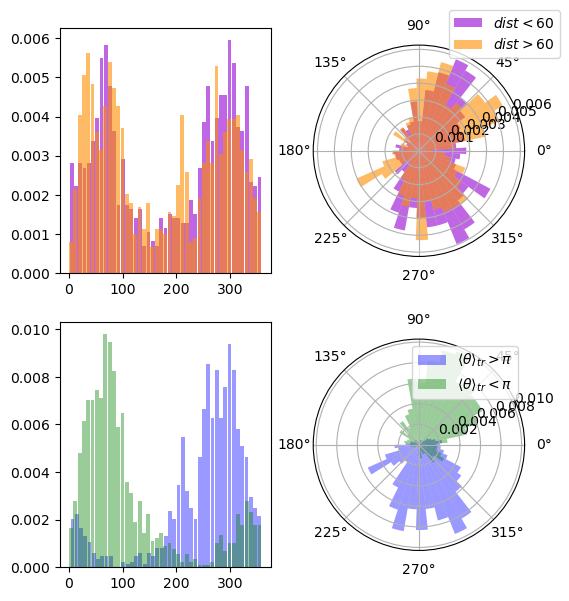

In [28]:
%matplotlib inline
dist = 60
bins_number = 45  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

y = (fuse_df["angp1_rel"]) % (2*np.pi)
# y_close = (fuse_df["angp1_rel"][fuse_df.index<30]) % (2*np.pi)
# y_far = (fuse_df["angp1_rel"][fuse_df.index>60]) % (2*np.pi)
y_close = (fuse_df["angp1_rel"][fuse_df["distance"]<dist]) % (2*np.pi)
y_far = (fuse_df["angp1_rel"][fuse_df["distance"]>dist]) % (2*np.pi)
y_up = (fuse_df["angp1_rel"][fuse_df["fuse_up"]]) % (2*np.pi)
y_down = (fuse_df["angp1_rel"][~fuse_df["fuse_up"]]) % (2*np.pi)

plt.figure(figsize=(6,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')

# p = ax1.hist(y, 60, alpha=.3, density=True, rwidth=.9)
p1,_,_ = ax1.hist(y_close*180/np.pi, 45, alpha=.6, density=True, rwidth=.9, color="darkviolet")
p2,_,_ = ax1.hist(y_far*180/np.pi, 45, alpha=.6, density=True, rwidth=.9, color="darkorange")
p3,_,_ = ax3.hist(y_up*180/np.pi, 45, alpha=.4, density=True, rwidth=.9, color="b")
p4,_,_ = ax3.hist(y_down*180/np.pi, 45, alpha=.4, density=True, rwidth=.9, color="g")


ax2.bar(bins[:bins_number], p1, color="darkviolet", width=width, bottom=0., alpha=.6, label="$dist<%s$" %dist)
ax2.bar(bins[:bins_number], p2, color="darkorange", width=width, bottom=0., alpha=.6, label="$dist>%s$" %dist)
ax4.bar(bins[:bins_number], p3, color="b", width=width, bottom=0., alpha=.4, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax4.bar(bins[:bins_number], p4, color="g", width=width, bottom=0., alpha=.4, label=r"$\langle \theta \rangle _{tr} < \pi$")
ax2.legend(bbox_to_anchor=(1.2, 1.2)); ax4.legend()

Text(0, 0.5, '$Angle$')

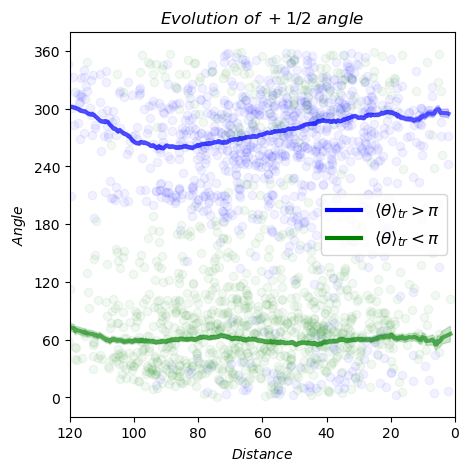

In [29]:
%matplotlib inline

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

df_all = fuse_df #create_df# 
ax1.plot(df_all.distance[fuse_df["fuse_up"]], df_all.angp1_rel[fuse_df["fuse_up"]]*180/np.pi, "ob", alpha=.05)
ax1.plot(df_all.distance[~fuse_df["fuse_up"]], df_all.angp1_rel[~fuse_df["fuse_up"]]*180/np.pi, "og", alpha=.05)

win = 15
  
df = df_all[fuse_df["fuse_up"]]
df_av_up = plot_rolling_average(df, ax1, "angp1_rel", "distance", win=win, color="b")
ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")


df = df_all[~fuse_df["fuse_up"]]
df_av_down = plot_rolling_average(df, ax1, "angp1_rel", "distance", win=win, color="g")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([0,120]); plt.ylim([-20,380]); plt.yticks(np.arange(0, 361, 60))
plt.gca().set_box_aspect(1); plt.gca().invert_xaxis()
plt.legend(fontsize=12); plt.title("$Evolution ~of ~+1/2 ~angle$")
plt.xlabel("$Distance$"); plt.ylabel("$Angle$")

## Relative amgle between defects in a pair

Text(0.5, 1.0, '$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$')

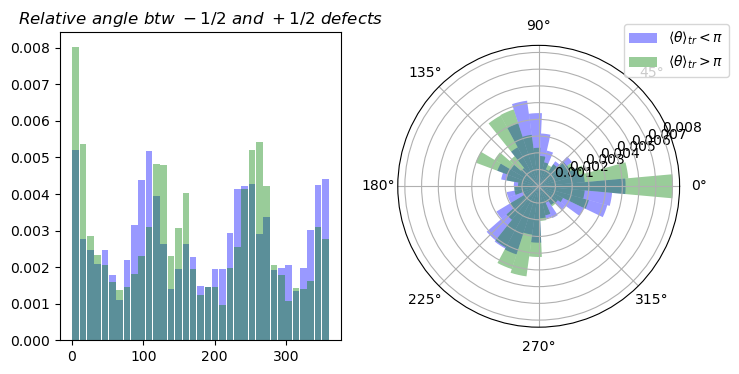

In [30]:
fig1 = plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 35  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

m_ang_all = []
for i in range(3):
    fuse_df["mp_angle"+str(i+1)]  = (fuse_df["angm"+str(i+1)] - fuse_df.angp1) % (2*np.pi)

mp_ang = []
mp_ang_up = []
mp_ang_down = []
for i in range(3):
    mp_ang.append(fuse_df["mp_angle"+str(i+1)].values)
    mp_ang_up.append(fuse_df["mp_angle"+str(i+1)][fuse_df.fuse_up].values)
    mp_ang_down.append(fuse_df["mp_angle"+str(i+1)][~fuse_df.fuse_up].values)   

mp_ang_up = np.array(mp_ang_up)
mp_ang_down = np.array(mp_ang_down)
fuse_df["mp_angle_av"]= circmean(mp_ang, axis=0, low=0., high=2/3*np.pi)

p1,_,_ = ax1.hist(mp_ang_up.ravel() *180/np.pi, bins*180/np.pi, # 3 paeks
# p1,_,_ = ax1.hist(fuse_df["mp_angle_av"][fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="b")# ,  df.shape  
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} < \pi$")

p2,_,_ = ax1.hist(mp_ang_down.ravel() *180/np.pi, bins*180/np.pi, # 3 paeks
# p2,_,_ = ax1.hist(fuse_df["mp_angle_av"][~fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="g")# ,  df.shape  
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} > \pi$")

ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax1.set_title(r"$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$")

Text(0, 0.5, '$Angle ~(deg)$')

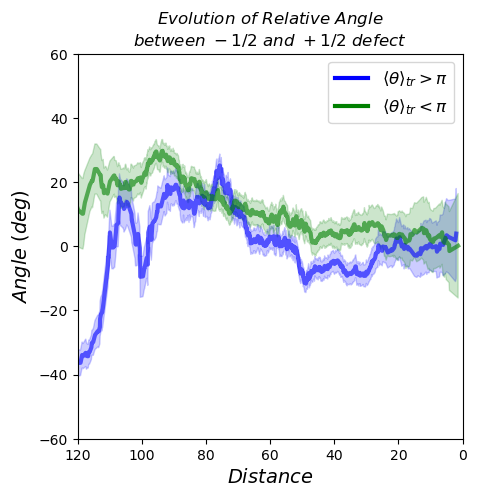

In [31]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

win = 5
# for i in range(3):
    # df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="b", low=-2/3*np.pi, high=0)
    # df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="g", low=0*np.pi, high=2/3*np.pi)


# ax1.plot(df_all.distance[fuse_df.fuse_up], (df_all.mp_angle_av[fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "ob", alpha=.05)
# ax1.plot(df_all.distance[~fuse_df.fuse_up], (df_all.mp_angle_av[~fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "og", alpha=.05)

df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="b", low=-1/3*np.pi, high=1/3*np.pi)
df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="g", low=-1/3*np.pi, high=1/3*np.pi)

ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([120,0]); plt.ylim([-60, 60]); #plt.yticks(np.arange(0, 121, 30))
plt.gca().set_box_aspect(1); #plt.gca().invert_xaxis()  
plt.legend(fontsize=12); 
plt.title(r"$Evolution ~of ~Relative ~Angle$" +"\n" + r"$between ~-1/2 ~and ~+1/2 ~defect$")
plt.xlabel(r"$Distance$", fontsize=14); plt.ylabel(r"$Angle ~(deg)$", fontsize=14)    

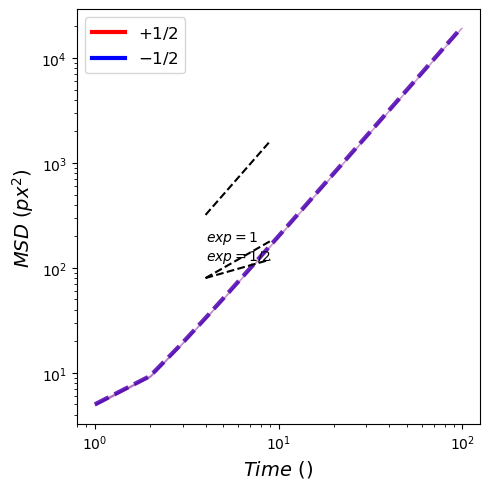

In [32]:
msds = []
for i in range(100):
    t_ = np.arange(0,1e2,1)
    x_ = i + t_ 
    y_ = i +  t_
    id = i

    msds.append(pd.DataFrame({"FRAME": t_, 'X':x_, 'Y':y_, "id": id})) 

df = pd.concat(msds)

df_msd = msd_from_df(df,"X","Y","FRAME","id")

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

dfs = [df_msd, df_msd]
colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 4e1*xref**.5, "--k", xref, 2e1*xref**1,"--k", xref, 2e1*xref**2,"--k")
ax1.text(xref[0], 4e1*xref[-1]**.5, r"$exp=1/2$", )
ax1.text(xref[0], 2e1*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


1
1


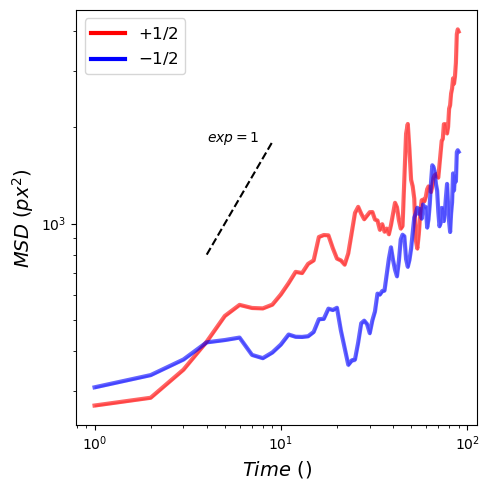

In [33]:
%matplotlib inline

# dist = 60
# msd_plus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xm","ym","FRAME","min_id")
# msd_plus_df_close = msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_close= msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xm","ym","FRAME","min_id")

msd_plus_df_far = msd_from_df(all_pairs_df.reset_index(),"xp","yp","FRAME","plus_id")
msd_minus_df_far = msd_from_df(all_pairs_df.reset_index(),"xm","ym","FRAME","min_id")

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

dfs = [msd_plus_df_far, msd_minus_df_far, ]#, msd_plus_df_close, msd_minus_df_close]
# dfs = [msd_plus_df_close, msd_minus_df_close]
colors = ["r","b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    # msd_df = msd_df.sort_values(by="FRAME")
    # msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    # msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    # msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    # ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    # ax1.fill_between(msd_df.FRAME, 
    #                 msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
    #                 msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
    #                 color=''.join(x for x in color if x.isalpha()), alpha=.2) 
    df = plot_rolling_average(msd_df, ax1, "MSD", "FRAME", win=win, color=color, avfunc=np.mean, stdfunc=np.std)
    print(df.FRAME.min())

ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 2e2*xref**1,"--k")
ax1.text(xref[0], 2e2*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


In [34]:
%matplotlib qt
# msd_df = msd_from_df(all_pairs_df.reset_index(),"xp","yp","FRAME","plus_id")

def msd(x,y):
    return np.cumsum(np.diff(x))**2 + np.cumsum(np.diff(y))**2

df = all_pairs_df.reset_index()

xlabel,ylabel,tlabel,id_label  = "xm","ym","FRAME","min_id"
xlabel,ylabel,tlabel,id_label  = "xp","yp","FRAME","plus_id"

msds = []
for id in df[id_label].unique():
    idx = (df[id_label]==id)
    df_ = df[idx].copy()
    if id==101:
        break
    if idx.sum()>3:
        t = df_[tlabel].to_numpy()        
        # t = t[1:] - t[0]               
        x = df_[xlabel].to_numpy()
        y = df_[ylabel].to_numpy()
        id_l = df_[id_label].to_numpy()
        msds.append(pd.DataFrame({'FRAME': t[1:] - t[0], 
                                  'MSD':msd(x,y),
                                  'ID': id_l[1:]
                                  }).dropna())            
ddf = pd.concat(msds)
msd_df = ddf[ddf["FRAME"]>=0].copy()
msd_df = msd_df.sort_values(by="FRAME")
msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, 3, func=np.mean)
plt.plot(msd_df.FRAME, msd_df["ave"],"-o", alpha=.6, linewidth=3)
# plt.xscale('log'); plt.yscale('log'); 
plt.gca().set_box_aspect(1)

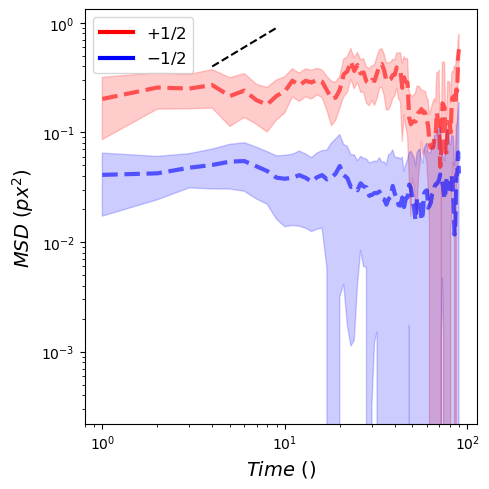

In [35]:
dist = 60
# msd_plus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xm","ym","FRAME","min_id")
# msd_plus_df_close = msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_close= msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xm","ym","FRAME","min_id")

# msd_plus_df_far = msd_from_df(all_pairs_df.reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df.reset_index(),"xm","ym","FRAME","min_id")
msd_plus_df_far = ang_msd_from_df(all_pairs_df.reset_index(),
                              "angp1","FRAME","plus_id", minimal_track=20)

msd_minus_df_far = ang_msd_from_df(all_pairs_df.reset_index(),
                               "angm1","FRAME","min_id",period=2/3*np.pi)



%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

dfs = [msd_plus_df_far, msd_minus_df_far]#, msd_plus_df_close, msd_minus_df_close]
# dfs = [msd_plus_df_close, msd_minus_df_close]
colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 1e-1*xref**1,"--k")
# ax1.text(xref[0], 4e2*xref[-1]**.5, r"$exp=1/2$", )
# ax1.text(xref[0], 2e2*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


Text(0.5, 1.0, '$Angle ~variation ~of ~+1/2 ~Defects$')

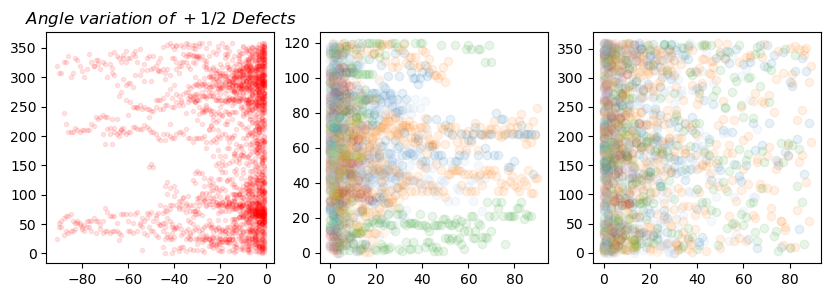

In [36]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
pangles_early = []
pangles_late = []
mangles = []
mpangles = []
p_vel_angles = []
p_vel_angles_rel = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    # pang = np.diff(angs[0])
    # ----------  TODO check how to --------------
    pang = angs[0] % (2*np.pi) #-angs[0][-1]
    # pang[pang<0] = pang[pang<0] + 2*np.pi
    ax[0].plot(-len(pang)+np.arange(len(pang)), (pang+np.pi % (2*np.pi))  * 180/np.pi-180, ".", color="red", alpha=.1)
    ax[1].plot(np.arange(len(angs[1][0])), angs[1][0] % (2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)

    pangles.append(angs[0][:-1])
    pangles_early.append(angs[0][:-10])
    pangles_late.append(angs[0][-10:])
    mangles.append(np.concatenate(angs[1]))
    p_vel_angles.append(angs[2])
    p_vel_angles_rel.append(angs[3])

    # mpangle = np.min((angs[1] - angs[0]) %(2*np.pi), axis=0)#[-3:]
    mpangles.append(np.concatenate(angs[1] - angs[0]))

    ax[2].plot(np.arange(len(angs[2])), np.array(angs[2]) %(2*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    
    # if num>25:
    #     break

# plt.figure(figsize=(3,3))
# plt.hist(np.concatenate(mpangles) % (2/3*np.pi) *180/np.pi , alpha=.2, rwidth=.9)
# ax[0].set_ylim([-10,370])
# ax[1].set_ylim([-10,130])
# ax[1].set_ylim([0,120])
# ax[0].set_xlim([-1,0])
ax[0].set_title("$Angle ~variation ~of ~+1/2 ~Defects$")
# ax[0].set_ylim([-100,100])

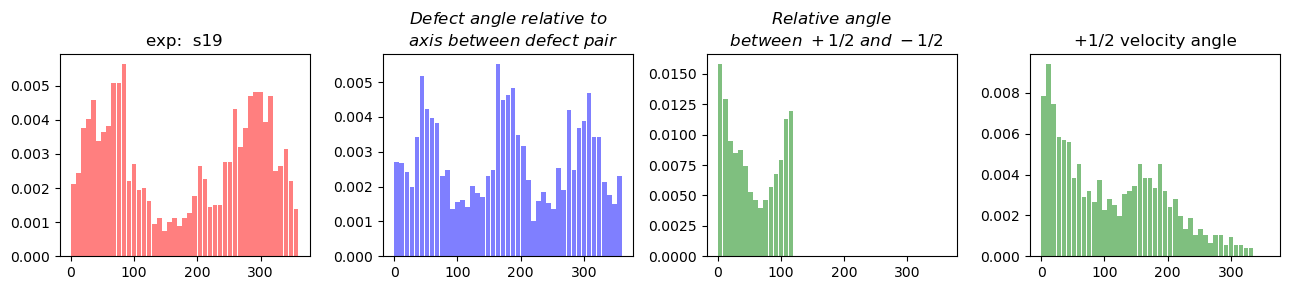

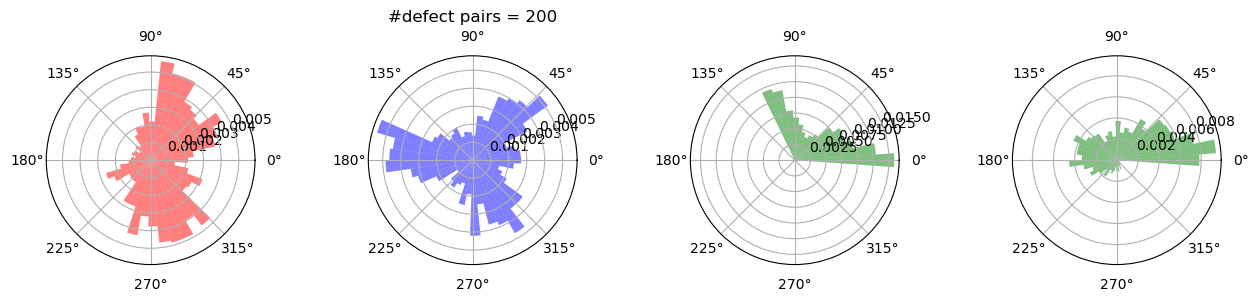

In [37]:
%matplotlib inline
SAVE = False
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
pangle = np.concatenate(pangles) + 0 * 2*np.pi
mangle = np.concatenate(mangles) + 0 * 2/3*np.pi #2*np.pi * np.ones((1,100)).ravel() #
mpangle = np.concatenate(mpangles) + 0 * 2/3*np.pi
p_vel_angle = np.concatenate(p_vel_angles) + 0 * 2*np.pi

pangle = pangle % (2*np.pi)
mangle = mangle % (2*np.pi)
mpangle = mpangle % (2/3*np.pi)

fig1, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(13,3))
ax1.set_title(r"exp:  " + experiment)
ax2.set_title("$Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair $")
ax3.set_title("$Relative ~angle$ \n $~between ~+1/2 ~and ~-1/2$")
ax4.set_title(r"+1/2 velocity angle")
pn, _, _ =  ax1.hist(pangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="red")
mn, _, _ = ax2.hist(mangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="blue")
mpn, _, _ =  ax3.hist(mpangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
p_vel, _, _ =  ax4.hist(p_vel_angle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
plt.tight_layout()
if SAVE:
    fig1.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_hist_" + experiment +".png")


# plt.clf()
width = 2 * np.pi / bins_number
fig2, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(13,3))
ax1.bar(bins[:bins_number], pn, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], mn, color="blue",width=width, bottom=0.0, alpha=.5)
ax3.bar(bins[:bins_number], mpn, color="green",width=width, bottom=0.0, alpha=.5)
ax4.bar(bins[:bins_number], p_vel, color="green",width=width, bottom=0.0, alpha=.5)
ax2.set_title(r"#defect pairs = " + str(len(pair_stat)))
plt.tight_layout()
if SAVE:
    fig2.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_polhist_" + experiment +".png")


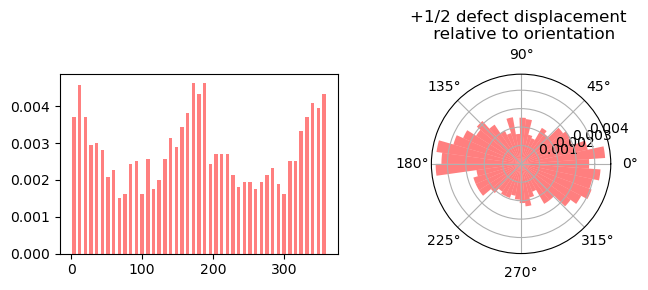

In [38]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p_vel_angle_rel =  np.concatenate(p_vel_angles) % (2*np.pi)

n, _, _ =  ax1.hist(p_vel_angle_rel*180/np.pi, bins*180/np.pi, density=True, rwidth=.6, alpha=.5, color="red")
ax2.bar(bins[:bins_number], n, color="red",width=width, bottom=0.0, alpha=.5)
plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
if SAVE:
    fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/p_direction_vs_displacement_" + experiment +".png")

Text(0.5, 1.0, 'Eary vs. Late +1/2 Defect Orienatation')

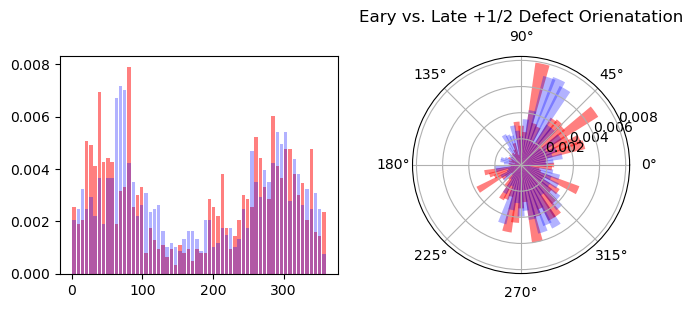

In [39]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 60
bins = np.linspace(0, 2*np.pi, bins_number+1)

pangle_early =  np.concatenate(pangles_early) % (2*np.pi)
pangle_late =  np.concatenate(pangles_late) % (2*np.pi)

n1, _, _ =  ax1.hist(pangle_early*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.5, color="red")
n2, _, _ =  ax1.hist(pangle_late*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.3, color="blue")
ax2.bar(bins[:bins_number], n1, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], n2, color="blue",width=width, bottom=0.0, alpha=.3)
# plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
plt.title("Eary vs. Late +1/2 Defect Orienatation")

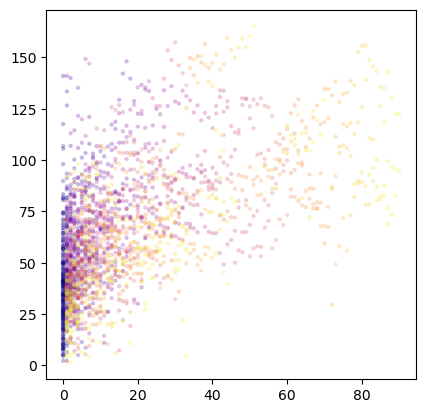

In [40]:
mp_distance_mat = np.zeros([len(mp_distance), len(max(mp_distance, key = lambda x: len(x)))])
mp_distance_mat[:] = np.nan
for i, dist in enumerate(mp_distance):
    # print(i, j)
    plt.scatter(np.arange(len(dist)), np.flip(dist), c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)    
    mp_distance_mat[i,0:len(dist)] = np.flip(dist)
    
plt.gca().set_box_aspect(1)  

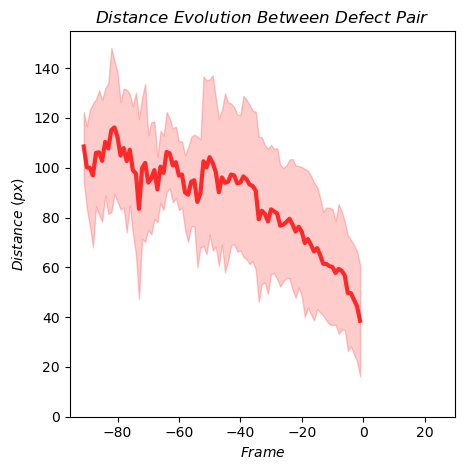

In [41]:
%matplotlib inline
for i in range(mp_distance_mat.shape[0]):
    y = mp_distance_mat[i,:][~np.isnan(mp_distance_mat[i,:])]
    # plt.scatter(np.arange(len(y)), y, c=np.arange(len(y)), s=3, alpha=.2, cmap="plasma")


mean, stdiv = np.flip(np.nanmean(mp_distance_mat, axis=0)), np.flip(np.nanstd(mp_distance_mat, axis=0))
max_frame = mp_distance_mat.shape[1]

plt.plot(np.arange(len(mean))-max_frame, mean, "r-", alpha=.8, linewidth=3)
plt.fill_between(np.arange(len(mean))-max_frame, mean-stdiv, mean+stdiv, color="red", alpha=.2)
plt.ylim([0,None])
plt.xlim([None,30])
plt.gca().set_box_aspect(1)  
plt.xlabel('$Frame$')
plt.ylabel(r'$Distance ~(px)$') #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pair$')
plt.tight_layout()
if SAVE:
    plt.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/defect_pair_distance_" + experiment +".png")

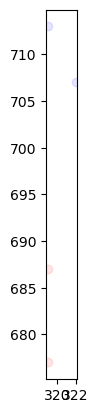

In [42]:
plt.plot(xp, yp,"ro", alpha=.1)
plt.plot(xm, ym,"bo", alpha=.1)
plt.gca().set_aspect(1)

## Flow Averaging Around Defects

In [43]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random
import pickle 

sys.path.append('../defect_functions') 
from defect_pairs import * 

experiment = "s19"
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID901391,901391,26.0,81.421509,657.0,88.0,0.0,0.0,0,...,0.973672,1.625018,1293.144897,1972.526759,1293.0,1972.0,2.073451,NaN,NaN,0.5
1,1,ID901390,901390,89.0,81.421509,860.0,86.0,0.0,0.0,0,...,0.973672,1.625018,1740.161345,1977.706022,1740.0,1978.0,0.000000,NaN,NaN,0.5
2,2,ID901405,901405,124.0,74.827904,242.0,205.0,0.0,0.0,0,...,0.977139,1.318006,379.293538,1669.539881,380.0,1670.0,-1.570796,NaN,NaN,0.5
3,3,ID901404,901404,35.0,81.421509,844.0,192.0,0.0,0.0,0,...,0.973672,1.625018,1704.928521,1703.205090,1705.0,1704.0,1.319469,NaN,NaN,0.5
4,4,ID901407,901407,34.0,81.421509,718.0,220.0,0.0,0.0,0,...,0.973672,1.625018,1427.470036,1630.695409,1427.0,1632.0,-1.759292,NaN,NaN,0.5


In [44]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

first_frame = minushalf_df["frame"].min()
last_frame = first_frame + plus_minus_df.FRAME.max()
# last_frame = minushalf_df["frame"].max() # Validate this number in image folders

### Read Defect Positions from CSV

In [45]:
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]

In [46]:
%matplotlib qt

frame = 12
# pdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == 0.5)]
# mdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == -0.5)]

df = all_pairs_df[all_pairs_df.index == frame]

im1 = image_list[frame]
# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

width, height = 300, 300

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
# ax.plot(pdf["x_img1"],
#         pdf["y_img1"],'go',
#         markersize=10, alpha=.8, label="TrackMate table")
# ax.quiver(pdf['x_img1'], pdf['y_img1'], 
#     np.cos(pdf['ang1']), -np.sin(pdf['ang1']), 
#     headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8, width=.01)
ax.plot(df["xp"], df["yp"],'mo', markersize=8, alpha=.8)
ax.quiver(df["xp"], df["yp"], 
    np.cos(df['angp1']), -np.sin(df['angp1']), 
    headaxislength=0, headwidth=0, headlength=0, color='m', scale=35, alpha=.8)

# -1/2
# ax.plot(mdf["x_img1"],
#         mdf["y_img1"],'bo',
#         markersize=10, alpha=.8, label="TrackMate table")
# for i in range(3):
#     ax.quiver(mdf["x_img1"], mdf["y_img1"], 
#         np.cos(mdf['ang'+str(i+1)]), -np.sin(mdf['ang'+str(i+1)]), 
#         headaxislength=0, headwidth=0, headlength=0, color='b', scale=30, alpha=.6)
ax.plot(df["xm"], df["ym"],'co', markersize=5, alpha=.8)
for i in range(3):
    ax.quiver(df["xm"], df["ym"], 
        np.cos(df['angm'+str(i+1)]), -np.sin(df['angm'+str(i+1)]), 
        headaxislength=0, headwidth=0, headlength=0, color='c', scale=35, alpha=.6)        


i_all = []
# for i in range(len(pdf["x_img1"])):
#         ulx, uly = pdf["x_img1"].iloc[i] - width//2, pdf["y_img1"].iloc[i] - height//2
#         lrx, lry = pdf["x_img1"].iloc[i] + width//2, pdf["y_img1"].iloc[i] + height//2

for i in range(len(df["xp"])):
        ulx, uly = df["xp"].iloc[i] - width//2, df["yp"].iloc[i] - height//2
        lrx, lry = df["xp"].iloc[i] + width//2, df["yp"].iloc[i] + height//2        
        if (ulx > 0) & (uly>0) & (lrx<w_img) & (lry<h_img):# & (i%2): #(i%1)
                color = "red" if df.fuse_up.iloc[i] else "blue"
                i_all.append(i)
                rect = plt.Rectangle((ulx, uly), 
                                width, height, color=color, fill=False)
                ax.text(lrx, lry, str(i), color='m', fontsize=20)
                ax.add_patch(rect)
print(i_all) 
plt.title("Frame: %s" % frame)               

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 34, 35, 36, 37, 38, 41, 42, 44, 46, 47]


Text(0.5, 1.0, 'Frame: 12')

## rotation angle in degree

In [47]:
all_pairs_df[all_pairs_df.index == frame].head()

,plus_id,xp,yp,angp1,min_id,xm,ym,angm1,angm2,angm3,distance,mp_angle,angp1_rel,angm1_rel,angm2_rel,angm3_rel,fuse_up,p_vel_angle,p_vel_angle_rel,angp1_rel_vel_angle
FRAME,,,,,,,,,,,,,,,,,,,,
12,34.0,1450.0,1643.0,-2.890265,0.0,1364.0,1716.0,-1.884956,-0.062832,2.010619,112.805142,2.437774,0.955146,1.960456,3.782579,5.856031,False,0.694738,-1.743036,2.698182
12,32.0,252.0,1554.0,0.188496,1.0,248.0,1638.0,-2.010619,-0.062832,2.199115,84.095184,1.618379,4.853301,2.654187,4.601974,0.580735,True,-1.570796,-3.189176,1.759292
12,32.0,252.0,1554.0,0.188496,4.0,205.0,1554.0,-2.890265,1.696460,-0.565487,47.000000,3.141593,3.330088,0.251327,4.838053,2.576106,True,-3.020969,-6.162562,3.209465
12,28.0,1429.0,1464.0,1.822124,5.0,1476.0,1520.0,1.884956,-2.136283,-0.062832,73.109507,0.872555,0.949568,1.012400,3.274347,5.347798,False,-0.197396,-1.069951,2.019519
12,100.0,222.0,1522.0,-2.701770,6.0,182.0,1432.0,-1.130973,1.130973,-3.015929,98.488578,4.294165,5.570436,0.858047,3.119994,5.256277,True,0.000000,0.000000,3.581416


Text(0.5, 1.0, '-151')

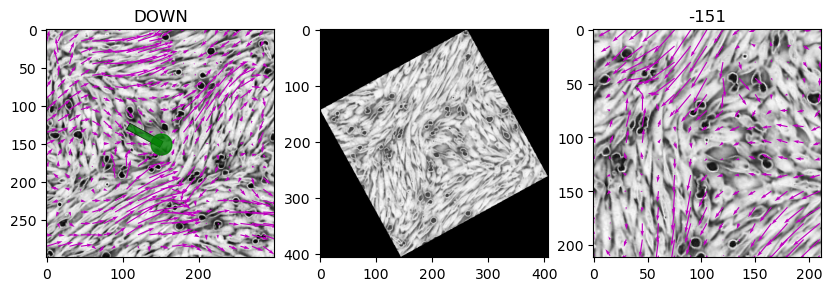

In [48]:
%matplotlib inline
from scipy.ndimage import rotate, gaussian_filter

def crop(img, center, width, height):
    ulx, uly = max(int(center[0] - width//2), 0), max(int(center[1] - height//2), 0)
    lrx, lry = min(int(center[0] + width//2), img.shape[1]), min(int(center[1] + height//2), img.shape[0])
    new_center = ((lrx-ulx)/2 , (lry-uly)/2)
    return img[uly:lry,ulx:lrx], new_center

def rotate_vector(vector, angle):
    '''rotate vectors'''
    x = vector[0] * np.cos(angle) - vector[1] * -np.sin(angle)
    y = vector[0] * -np.sin(angle) + vector[1] * np.cos(angle)
    return [x, y]    

def rotate_flow_field(flow, angle):
    '''rotate flow field'''
    uv_rot = rotate_vector(flow, angle)
    u = rotate(uv_rot[0], angle * 180/np.pi)
    v = rotate(uv_rot[1], angle * 180/np.pi)
    return [u, v]  


i = i_all[11]
# i=4

frame = frame
width, height = 300, 300

img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0] 

flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
u, v = flow[:,:,0], flow[:,:,1]
u = gaussian_filter(u, sigma=15)
v = gaussian_filter(v, sigma=15)
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]


# pdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == 0.5)]
# mdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == -0.5)]
df = all_pairs_df[(all_pairs_df.index == frame) & (all_pairs_df.fuse_up)]

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

# fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.imshow(255-img_clahe, "gray")
# step = 15
# ax.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=50, color='m', alpha=.6, width=.005)
# ulx, uly  = pdf["x_img1"].iloc[i] - width//2, pdf["y_img1"].iloc[i] - height//2
# ulx, uly  = df["xp"].iloc[i] - width//2, df["yp"].iloc[i] - height//2
# rect = plt.Rectangle((ulx, uly), 
#                 width, height, color="b", fill=False, linewidth=3)
# ax.add_patch(rect)

# cnt = (int(pdf["x_img1"].iloc[i]), int(pdf["y_img1"].iloc[i]))
cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
image_crop, new_cnt = crop(255-img_clahe, cnt, width, height)

# velocity field
# u = np.ones_like(image_crop)
# v = .5* u
u,_ = crop(flow[:,:,0], cnt, width, height)
v,_ = crop(flow[:,:,1], cnt, width, height)
u = gaussian_filter(u, sigma=15)
v = gaussian_filter(v, sigma=15)
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(image_crop, "gray")
step = 15
ax1.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=30, color='m',
     width=.005)

ax1.plot(new_cnt[0], new_cnt[1],'go', markersize=15, alpha=.8, label="TrackMate table")
# ax1.quiver(new_cnt[0], new_cnt[1], np.cos(pdf['ang1'].iloc[i]), -np.sin(pdf['ang1'].iloc[i]), 
#     headaxislength=0, headwidth=0, headlength=0, color='g', scale=6, alpha=.8, 
#     width=.03, linewidth=.5, edgecolor='k')
ax1.quiver(new_cnt[0], new_cnt[1], np.cos(df['angp1'].iloc[i]), -np.sin(df['angp1'].iloc[i]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=6, alpha=.8, 
    width=.03, linewidth=.5, edgecolor='k')

title = "UP" if df.fuse_up.iloc[i] else "DOWN"
ax1.set_title("DOWN")

#rotation angle in degree
# image_rot = rotate(image_crop, pdf["ang1"].iloc[i] * 180/np.pi)
image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi)
ax2.imshow(image_rot, "gray")

cnt = image_rot.shape[1]/2, image_rot.shape[0]/2
width1, height1 = (width/2**.5), (height/2**.5)
image_rot_crop, new_cnt = crop(image_rot, cnt, width1, height1)

ax3.imshow(image_rot_crop, "gray")

# uv_rot = rotate_flow_field((u,v), pdf["ang1"].iloc[i])
uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])
u = crop(uv_rot[0], cnt, width1, height1)[0]
v = crop(uv_rot[1], cnt, width1, height1)[0]
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]

ax3.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=30, color='m',
     width=.005)

plt.title("%2d"%(df["angp1"].iloc[i] * 180/np.pi))

### Average defect ensable

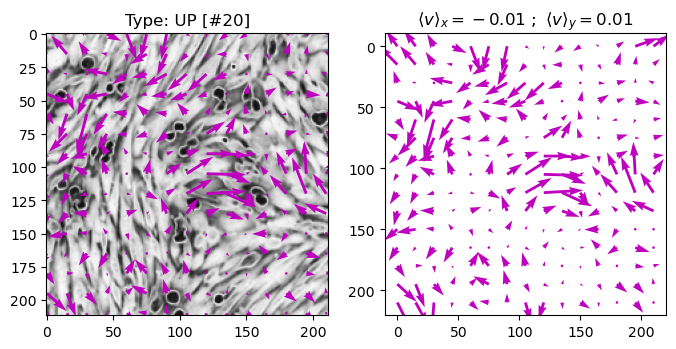

In [49]:
%matplotlib inline

frame = 5
filt = 5 # smoothing average
width, height = 300, 300
width1, height1 = int(width/2**.5), int(height/2**.5)

img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0] 
flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow = gaussian_filter(flow, sigma=filt)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1) 

u_frame = np.zeros((height1, width1), dtype=np.float32)
v_frame = u_frame
count = 0

for i in i_all:
# TODO replace try with padding of boundary defects   
        # print(i)   
        try:
                if df.fuse_up.iloc[i]:  
                        # center at defect position
                        cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
                        #1 crop each component of velocity field
                        
                        # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
                        u,_ = crop(flow[:,:,0], cnt, width, height)
                        v,_ = crop(flow[:,:,1], cnt, width, height)

                        #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
                        # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
                        uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])

                        #3 crop again to smaller box (box**0.5)
                        cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
                        # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
                        u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
                        v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
                        count += 1 
                        # break
                        defect_type = "UP" if df.fuse_up.iloc[i] else "DOWN"
        except:
                pass
        #      break

u_frame /= count
v_frame /= count
y, x = np.mgrid[0:height1, 0:width1] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(image_rot_crop, "gray")
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_frame[::step, ::step], -v_frame[::step, ::step],  color='m',
          width=.01, scale=6,)
ax1.set_title("Type: %1s [#%1d]" % (defect_type, count))

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_frame[::step, ::step], -v_frame[::step, ::step],  color='m',
          width=.01, scale=6,)
ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_box_aspect(1)
ax2.invert_yaxis()

### average sigle frame

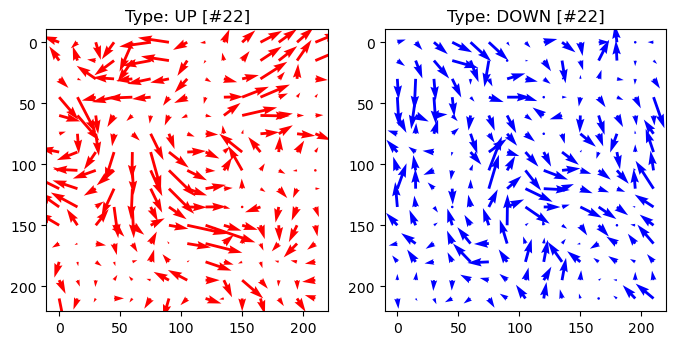

In [50]:
%matplotlib inline

def defect_flow_frame_average(img1,img2, df_frame, defect_type="up", box=(300,300), filt=5):
    width, height = box[0], box[1]
    width1, height1 = int(width/2**.5), int(height/2**.5)
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow = gaussian_filter(flow, sigma=filt)

    if defect_type=="up":
        df = df_frame[df_frame.fuse_up].copy()
    else:
        df = df_frame[~df_frame.fuse_up].copy()

    u_frame = np.zeros((height1, width1), dtype=np.float32)
    v_frame = u_frame
    count = 0

    for i in range(len(df["xp"])):
        try:
            # center at defect position
            cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
            #1 crop each component of velocity field
            
            # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
            u,_ = crop(flow[:,:,0], cnt, width, height)
            v,_ = crop(flow[:,:,1], cnt, width, height)

            #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
            # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
            uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])

            #3 crop again to smaller box (box**0.5)
            cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
            # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
            u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
            v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
            count += 1 
        except:
            pass
        #      break

    if count:
        return u_frame/count, v_frame/count, count

frame = 12
img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0]  
df_frame = all_pairs_df[all_pairs_df.index == frame]

u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="up")
u_dwn, v_dwn, up_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="down")
y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
step = 15
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='r',
          width=.01, scale=6,)
ax1.set_title("Type: %1s [#%1d]" % ("UP", count_up))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='b',
          width=.01, scale=6,)
# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", count_up))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()


### average multiple frames

u_ups, v_ups, count_ups = [], [], []
u_dwns, v_dwns, count_dwns = [], [], []

all_frames = all_pairs_df.index.unique().values

for frame in all_frames:
    img1 = cv2.imread(image_list[frame])[:,:,0] 
    img2 = cv2.imread(image_list[frame+1])[:,:,0]  
    df_frame = all_pairs_df[all_pairs_df.index == frame]
    u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="up", filt=1)
    u_dwn, v_dwn, count_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="down", filt=1)

    u_ups.append(u_up)
    v_ups.append(v_up)
    count_ups.append(count_up)

    u_dwns.append(u_dwn)
    v_dwns.append(v_dwn)
    count_dwns.append(count_dwn)

    if frame % 5:
        save_path = r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" +experiment+ "/av_flows.pkl"

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
                pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
                                u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
                                ), f)  

    progressBar(frame, len(all_frames))


save_path = r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" +experiment+ "/av_flows.pkl"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
        pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
                        u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
                        ), f)  

In [51]:
save_path = r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" +experiment+ "/av_flows.pkl"
with open(save_path, 'rb') as f:
    av_flow = pickle.load(f) 

In [52]:
u_ups = np.array(av_flow["u_ups"])
v_ups = np.array(av_flow["v_ups"])
count_ups = np.array(av_flow["count_ups"])

u_dwns = np.array(av_flow["u_dwns"])
v_dwns = np.array(av_flow["v_dwns"])
count_dwns = np.array(av_flow["count_dwns"])

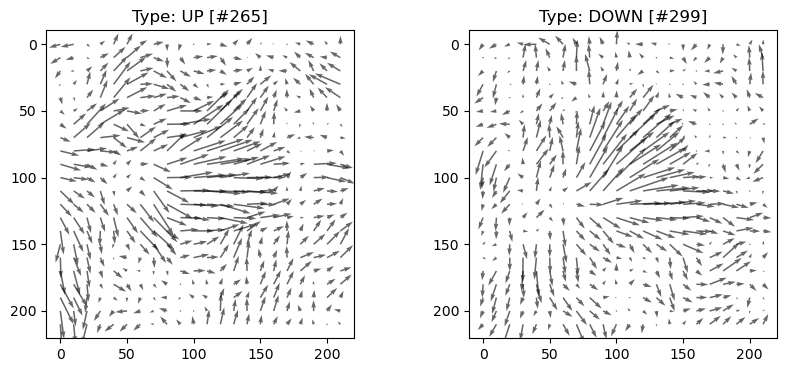

In [53]:
%matplotlib inline

# remove zero counts
u_ups = np.array(u_ups)
v_ups = np.array(v_ups)
count_ups = np.array(count_ups)

u_dwns = np.array(u_dwns)
v_dwns = np.array(v_dwns)
count_dwns = np.array(count_dwns)

tmin, tmax = 40, 94
idx = np.arange(tmin, tmax)
filt = 20

u_up = np.average(u_ups[count_ups!= 0][idx], axis=0, weights=count_ups[count_ups!= 0][idx])
v_up = np.average(v_ups[count_ups!= 0][idx], axis=0, weights=count_ups[count_ups!= 0][idx])

u_dwn = np.average(u_dwns[count_dwns!= 0][idx], axis=0, weights=count_dwns[count_dwns!= 0][idx])
v_dwn = np.average(v_dwns[count_dwns!= 0][idx], axis=0, weights=count_dwns[count_dwns!= 0][idx])

y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
step = 10

field = np.stack((u_up, v_up), axis=-1)
# vorticity = gaussian_filter(divergence_npgrad(field), sigma=filt)
# c = ax1.imshow(vorticity.T, cmap='RdBu', vmin=-.005, vmax=.005)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='k',
          width=.005, scale=4, alpha=.6)
ax1.set_title("Type: %1s [#%1d]" % ("UP", np.sum(count_ups[idx])))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()
# fig.colorbar(c, ax=ax1)

field = np.stack((u_dwn, v_dwn), axis=-1)
# vorticity = gaussian_filter(divergence_npgrad(field), sigma=filt)
# c = ax2.imshow(vorticity.T, cmap='RdBu', vmin=-.005, vmax=.005)

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=4, alpha=.6)       

# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns[idx])))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()
# fig.colorbar(c, ax=ax2)

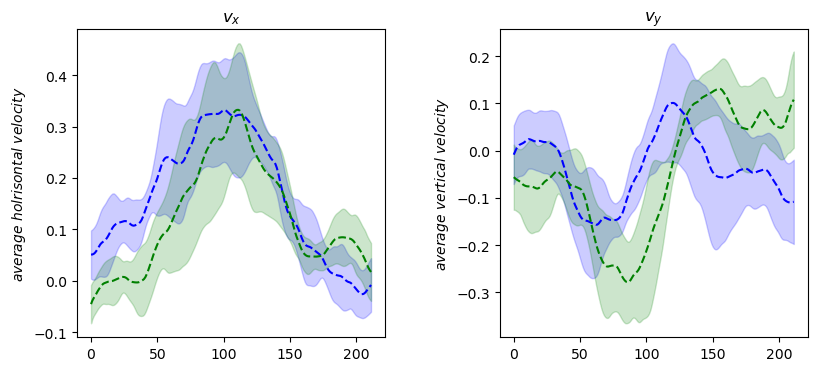

In [54]:
def section(mat, sec_axis="x"):
    ax = 0 if sec_axis=="x" else 1
    section_av = mat.mean(axis=ax)
    section_std = mat.std(axis=ax)
    xx = np.arange(len(section_av))
    return xx, section_av, section_std


c = u_up.shape[0]//2
dc = 50

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
xx, av, std  = section(u_up[:,c-dc:c+dc], sec_axis="y")
ax1.plot(xx, av, "--b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
xx, av, std  = section(v_up[:,c-dc:c+dc], sec_axis="y")
ax2.plot(xx, av, "--b")
ax2.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
ax1.set_title(r"$v_x$"); ax1.set_ylabel(r"$average ~holrisontal ~velocity$"); ax1.set_box_aspect(1)

xx, av, std  = section(u_dwn[:,c-dc:c+dc], sec_axis="y")
ax1.plot(xx, av, "--g")
ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
xx, av, std  = section(v_dwn[:,c-dc:c+dc], sec_axis="y")
ax2.plot(xx, av, "--g")
ax2.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
ax2.set_title(r"$v_y$"); ax2.set_ylabel(r"$average ~vertical ~velocity$"); ax2.set_box_aspect(1)

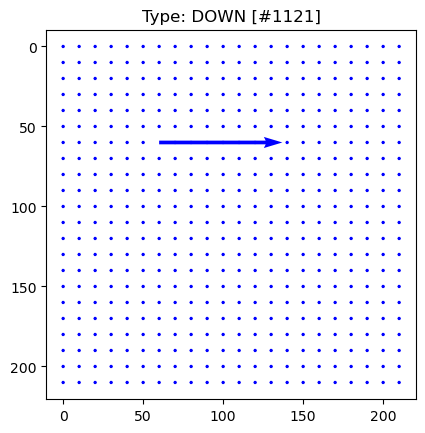

In [55]:
a = 0* np.ones_like(u_dwn)
b = 0* np.ones_like(u_dwn)
a[step*6,step*6] = 1
plt.figure()
plt.quiver(x[::step, ::step], y[::step, ::step], 
          a[::step, ::step], -b[::step, ::step],  color='b',
          width=.01, scale=3,)
plt.gca().set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns)))
plt.gca().set_box_aspect(1) ; plt.gca().invert_yaxis()